# Gene Array Report

By Jonathan Yin

## Data Overview

The dataset consists of 33 CSV files representing well slides, organized into 11 sets with each set performed in triplicate.

#### Slide Design

Each slide contains 384 wells arranged in a 16×24 formation, with 320 unique genes and 64 controls. The genes are located in the center 16×20 region, while the controls occupy the outer 2 columns on each side. There are 4 types of controls used: "rf", "fit1", "bscl2", and "rfnotDL".

![image](plots/ArrayDesign.png)

#### Measurements

For measurement purposes, each well on each slide was captured 7 times, with each capture generating a 130-dimensional feature vector (X1, X2, ..., X130).


In [1]:
import os
import pandas as pd
from pathlib import Path
from constants import METADATA_COLS, FEATURE_COLS

# Define the directory path
slidefiles_dir = Path("data/SlideFiles")

# List all files in the directory
csv_files = os.listdir(slidefiles_dir)

raw_df = pd.DataFrame()
for csv_file in csv_files:
    file_path = slidefiles_dir / csv_file
    raw_df = pd.concat([raw_df, pd.read_csv(file_path)])

raw_df = raw_df.sort_values(by=["slide", "well"])

## Data Cleaning and Normalization

### Feature Aggregation

First, we compute a single 130-dimensional feature vector for each well. We do this by taking the median of the 7 measurements across the 130 features. This makes the well measurements more robust to noise and easier to analyze.


In [2]:
df = raw_df.groupby(["slide", "well"]).agg(
    {
        **{col: "median" for col in FEATURE_COLS},
        **{col: "first" for col in METADATA_COLS if col not in ["well", "slide"]},
    }
)
# Reset index to make set and well regular columns again and re-order columns to match raw_df
df = df.reset_index()
df = df[raw_df.columns.tolist()]
df = df.sort_values(by=["slide", "well"])

### Normalize Systematic Slide-level Differences

To be able to compare wells across different slides, we need to account for potential systematic differences between slides. We can investigate the systematic differences between slides by establishing a baseline for each slide and see how each slide's baseline compares to a baseline across all slides.

Two approaches: RF normalization vs gene well normalization

Gene normalization: Each dimension is normally distributed, and we expect the means + variances to be the same. We can just normalize each dimension to have mean 0 and variance 1.

We use the rf (negative control) wells to establish a baseline for each slide since they should be identical across slides. For each slide, we have 24 rf wells, so we compute an rf baseline by taking the median of the 24 measurements for each of the 130 dimensions. This produces a single 130-dimensional rf feature vector for each slide.

For the global-level rf baseline, we do a similar computation, except over all the rf wells across all the slides. We have a total of 33x24=792 rf wells across the 33 slides, so for each of 130 dimensions, we take the median of 792 measurements corresponding to that dimension.

Now we have a 130-dimensional rf baseline for each slide and a 130-dimensional global-level rf baseline. It's also important to consider the variability of the rf wells. We can do this by computing the standard deviation of the rf wells' feature vectors.

We compare

We can now see how each slide's feature vectors by subtracting the slide-level rf baseline from the feature vectors and then dividing by the global-level rf baseline.

This centers the data around 0 and makes it easier to see the relative differences between wells.

(Add explanation of why we don't use gene wells even though they are likely negative hits because their feature vectors are variable)


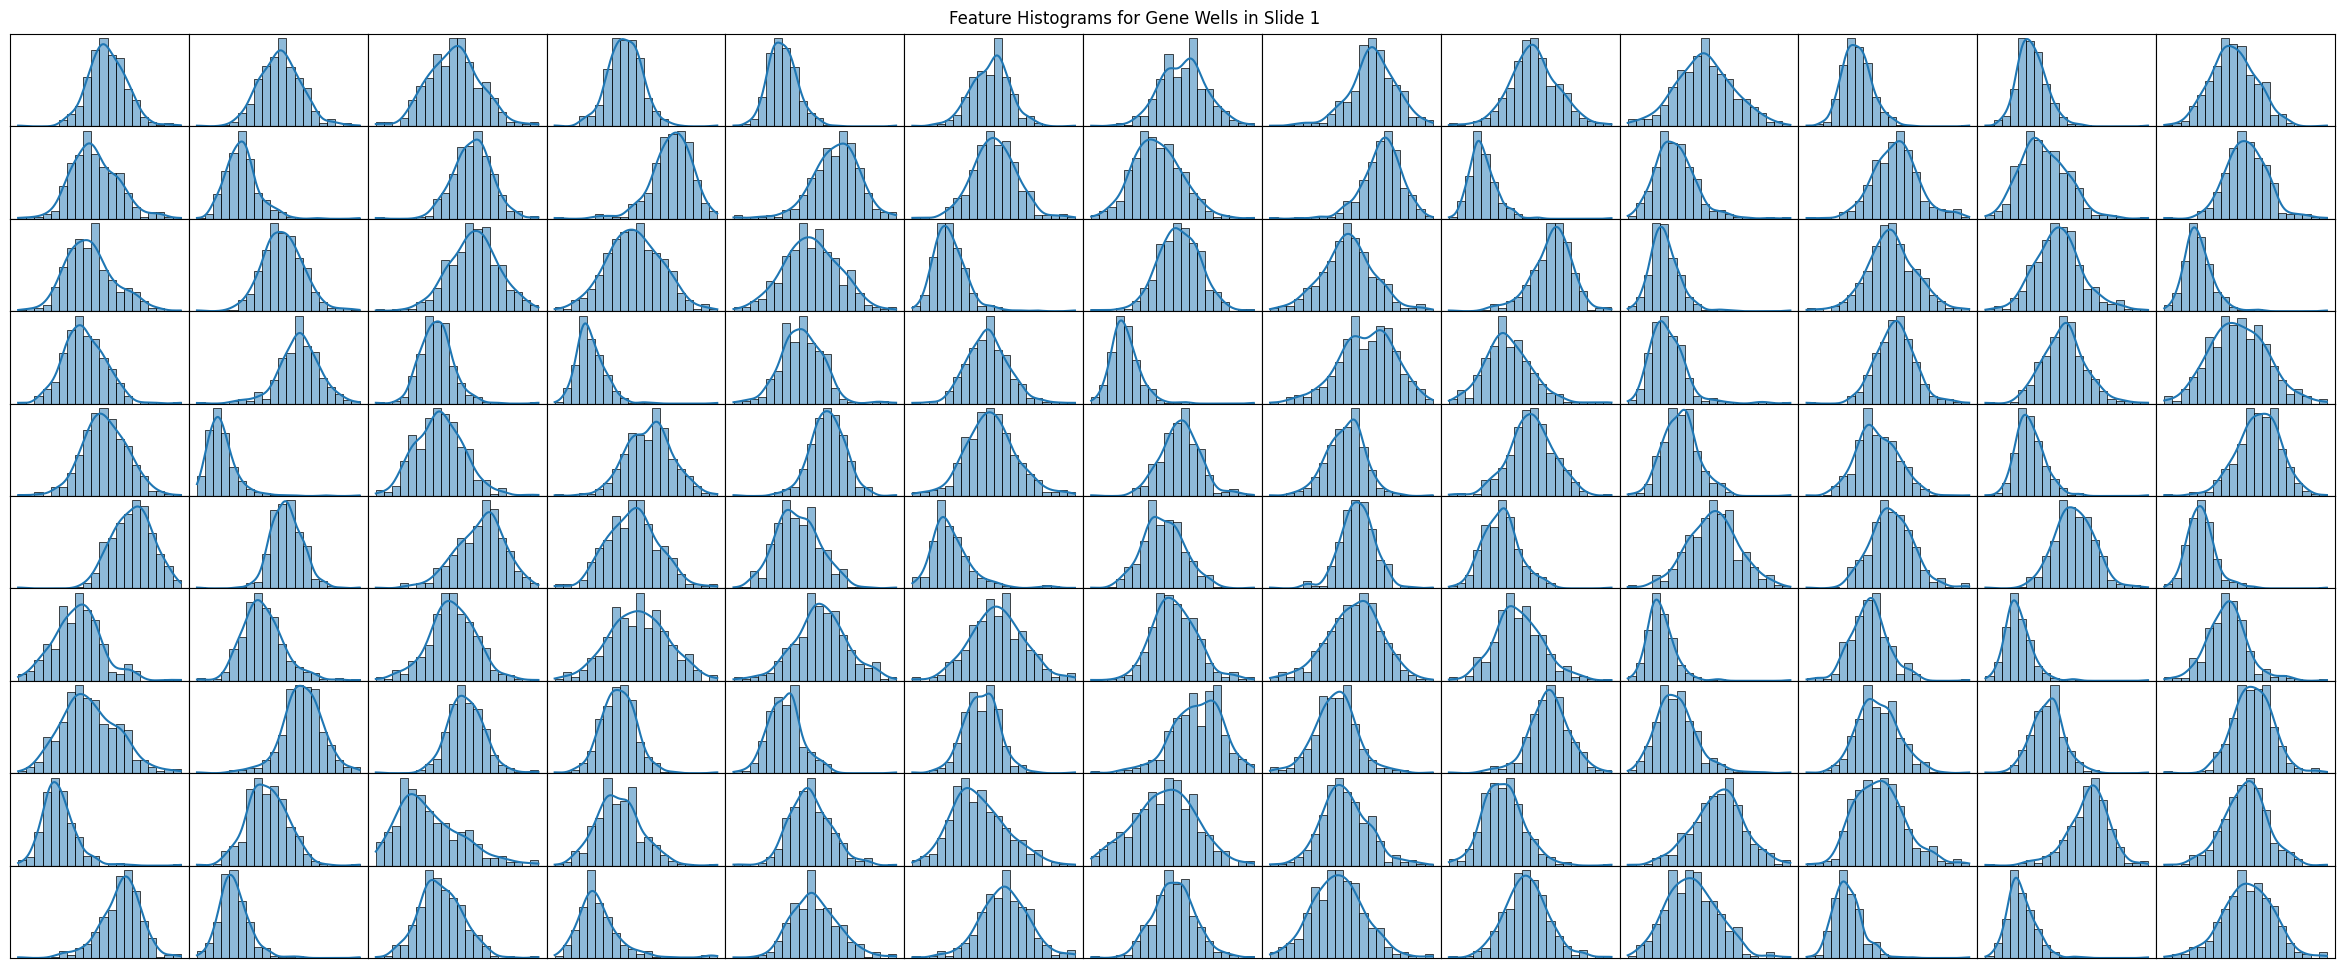

In [3]:
from plotting_utils import plot_feature_histograms


# for slide_number in df["slide"].unique():
#     plot_feature_histograms(
#         df[
#             (df["slide"] == slide_number) & (df["type"] == "gene")
#         ],
#         f"Feature Histograms for Gene Wells in Slide {slide_number}",
#     )

slide_number = 1
plot_feature_histograms(
    df[(df["slide"] == slide_number) & (df["type"] == "gene")],
    f"Feature Histograms for Gene Wells in Slide {slide_number}",
)

In [4]:
# Process each slide
for slide_number in df["slide"].unique():
    # Get indices for current slide
    slide_indices = df["slide"] == slide_number

    # Get the gene rows for this slide
    gene_indices = slide_indices & (df["type"] == "gene")

    if gene_indices.any():
        # Calculate mean and standard deviation for feature columns
        gene_means = df.loc[gene_indices, FEATURE_COLS].mean()
        gene_stds = df.loc[gene_indices, FEATURE_COLS].std()

        # Normalize all rows for this slide by subtracting mean and dividing by std
        for feature in FEATURE_COLS:
            df.loc[slide_indices, feature] = (
                df.loc[slide_indices, feature] - gene_means[feature]
            ) / gene_stds[feature]
    else:
        print(f"Warning: No gene rows found for slide {slide_number}")

### Triplicate Aggregation

Finally, we aggregate the triplicate slides by taking the median of the feature vectors for each well position. This produces a 130-dimensional feature vector for each well position in the set. This leaves us with 11 slides of 384 wells, each with a 130-dimensional feature vector.


In [5]:
# Group by set and well to aggregate across triplicates
df = df.groupby(["set", "well"]).agg(
    {
        **{col: "median" for col in FEATURE_COLS},
        **{
            col: "first" for col in METADATA_COLS if col not in ["well", "set", "slide"]
        },
    }
)

df = df.reset_index()
columns_to_keep = [col for col in raw_df.columns.tolist() if col != "slide"]
df = df[columns_to_keep]
df = df.sort_values(by=["set", "well"])

# Save to CSV
df.to_csv("data/cleaned_gene_array_data.csv", index=False)


## Outlier Detection


In [6]:
df_data = df[FEATURE_COLS].values
gene_df = df[df["type"] == "gene"]
gene_data = gene_df[FEATURE_COLS].values

In [7]:
from scipy.spatial import distance
import numpy as np


# Calculate the mean vector and covariance matrix of the gene data
gene_mean = np.mean(gene_data, axis=0)
gene_cov = np.cov(gene_data, rowvar=False)


# Calculate Mahalanobis distance for each row in the dataframe
df["mahalanobis_distance"] = df.apply(
    lambda row: distance.mahalanobis(
        row[FEATURE_COLS], gene_mean, np.linalg.inv(gene_cov)
    ),
    axis=1,
)

# Calculate the threshold using only the gene data
threshold = np.percentile(
    df[df["type"] == "gene"]["mahalanobis_distance"], (1 - (100 / 3520)) * 100
)

# Create a new column indicating whether each sample exceeds the threshold
df["mahalanobis_outlier"] = df["mahalanobis_distance"] > threshold

outlier_summary = df.groupby("type")["mahalanobis_outlier"].agg(["count", "sum"])
outlier_summary["percentage"] = (
    outlier_summary["sum"] / outlier_summary["count"]
) * 100
print(outlier_summary)

         count  sum  percentage
type                           
bscl2      176  166   94.318182
fit1        88    6    6.818182
gene      3520  100    2.840909
rf         264   20    7.575758
rfnotDL    176  172   97.727273


In [8]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=0, contamination=100 / 3520).fit(gene_data)
outlier_scores = clf.predict(df[FEATURE_COLS].values)

# outlier_scores = IsolationForest(
#     random_state=0, contamination=((176) * 2 + 100) / 3520
# ).fit_predict(df[FEATURE_COLS].values)

df["isolation_forest_outlier"] = outlier_scores == -1

outlier_summary = df.groupby("type")["isolation_forest_outlier"].agg(["count", "sum"])
outlier_summary["percentage"] = (
    outlier_summary["sum"] / outlier_summary["count"]
) * 100
print(outlier_summary)


         count  sum  percentage
type                           
bscl2      176  171   97.159091
fit1        88   10   11.363636
gene      3520  100    2.840909
rf         264   13    4.924242
rfnotDL    176  166   94.318182


# Visualization


In [9]:
import pandas as pd


def create_dimension_reduction_df(
    transformed_data,
    n_components,
    prefix,
    df,
):
    transformed_data = transformed_data[:, :n_components]
    columns = [f"{prefix}{i + 1}" for i in range(n_components)]
    result_df = pd.DataFrame(transformed_data, columns=columns)

    # Add metadata columns from original DataFrame
    for col in df.columns:
        if col not in FEATURE_COLS:
            result_df[col] = df[col].values

    return result_df

### PCA

![image](plots/isolation_forest_pca_3d_scatter.png)


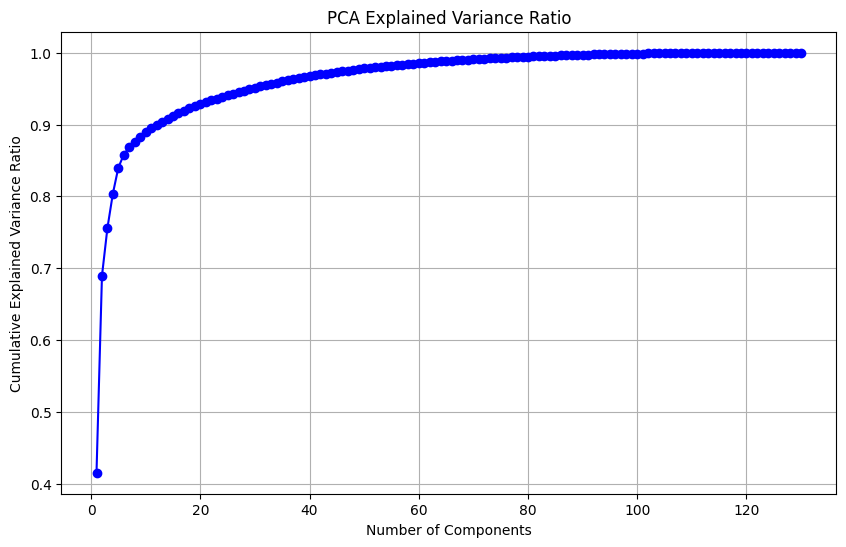

In [10]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
from plotting_utils import plot_3d_scatter


def perform_pca(X_scaled, plot_explained_variance=True):
    """Perform PCA and return transformed data and PCA object."""
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    if plot_explained_variance:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        plt.figure(figsize=(10, 6))
        plt.plot(
            range(1, len(explained_variance_ratio) + 1),
            cumulative_variance_ratio,
            "bo-",
        )
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance Ratio")
        plt.title("PCA Explained Variance Ratio")
        plt.grid(True)
        plt.show()
    return X_pca


HOVER_COLS = [
    "row",
    "col",
    "set",
]

X_pca = perform_pca(df_data, plot_explained_variance=True)


pca_df = create_dimension_reduction_df(
    X_pca,
    3,
    "PC",
    df,
)

pca_fig = plot_3d_scatter(
    pca_df,
    "PC1",
    "PC2",
    "PC3",
    title="3D PCA Projection",
    hover_data=HOVER_COLS,
    type_col="type",
    outlier_col="isolation_forest_outlier",
    filename="plots/isolation_forest_pca_3d_scatter",
)


### UMAP

![image](plots/isolation_forest_umap_3d_scatter.png)


In [11]:
# Apply UMAP for dimensionality reduction

from umap import UMAP


def perform_umap(data, n_components=3, n_neighbors=200, min_dist=0.8):
    """Perform UMAP dimensionality reduction on the input data."""
    umap_model = UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    umap_result = umap_model.fit_transform(data)
    return umap_result


# Perform UMAP and create DataFrame
X_umap = perform_umap(df_data)
umap_df = create_dimension_reduction_df(X_umap, 3, "UMAP", df)

# Plot UMAP results
umap_fig = plot_3d_scatter(
    umap_df,
    "UMAP1",
    "UMAP2",
    "UMAP3",
    title="3D UMAP Projection",
    type_col="type",
    hover_data=HOVER_COLS,
    outlier_col="isolation_forest_outlier",
    filename="plots/isolation_forest_umap_3d_scatter",
)


/Users/jyin/Documents/Yale Spring 2025/S&DS 425/GeneArray/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

